In [1]:
# # header
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2


In [2]:

# # built-in modules
import os
import argparse
from pprint import pformat
from collections import OrderedDict
import random
# # Torch modules
import torch
# # internal imports
from prelude import load_dicts, startup_folders, get_device, save_results_to_csv
from src.composer import ShapeRecognition_FBG
from src.model import AttentionModel
from src.utils import plot_all, plot_loss_all
from src.utils import build_loaders, get_n_parameters
from src.conductor import AttentionTrain


In [3]:
# start_folder = r"/Users/saeedida/GitProjects/bio-attention/results/__newer_era/results/shape_rec/1741263873"  # Attention
start_folder = r"/Users/saeedida/GitProjects/bio-attention/results/__newer_era/results/shape_rec/1741267182"  # FForward
results_folder, logger = startup_folders(start_folder, name=f"exp_mm_search")
data_path = r"../data"

/Users/saeedida/GitProjects/bio-attention/results/__newer_era/results/shape_rec/1741267182/1741274949 was created!


In [4]:
model_params = load_dicts(start_folder, "model_params")
tasks = load_dicts(start_folder, "tasks")
train_params = load_dicts(start_folder, "train_params")
DeVice, num_workers, pin_memory = get_device()
print(f"model_params: {model_params}")
print(f"tasks: {tasks}")
print(f"train_params: {train_params}")

Device set to mps
model_params: {'in_dims': [3, 128, 128], 'n_classes': 19, 'out_dim': 32, 'normalize': True, 'softness': 0.5, 'channels': [3, 16, 16, 32, 32, 64, 64, 128], 'residuals': False, 'kernels': 3, 'strides': 1, 'paddings': 1, 'conv_bias': True, 'conv_norms': [None, 'layer', 'layer', 'layer', 'layer', 'layer', 'layer'], 'conv_dropouts': 0.0, 'conv_funs': ReLU(), 'deconv_funs': Tanh(), 'deconv_norms': [None, 'layer', 'layer', 'layer', 'layer', 'layer', 'layer'], 'pools': [2, 2, 2, 2, 2, 2, 1], 'rnn_dims': [64], 'rnn_bias': True, 'rnn_dropouts': 0.0, 'rnn_funs': ReLU(), 'n_tasks': 1, 'task_weight': True, 'task_bias': True, 'task_funs': Tanh(), 'norm_mean': [0.5, 0.5, 0.5], 'norm_std': [1.0, 1.0, 1.0], 'rnn_to_fc': True, 'trans_fun': ReLU()}
tasks: {'Recognition': {'composer': 'ShapeRecognition_FBG', 'key': 0, 'params': {'n_iter': 1, 'directory': './data'}, 'datasets': ['ShapeRecognition_FBG', 'ShapeRecognition_FBG', 'ShapeRecognition_FBG'], 'dataloaders': [None, None, None], 'lo

In [5]:
# # setting up the tasks
tasks['Recognition']["composer"] = ShapeRecognition_FBG
tasks['Recognition']["datasets"] = []
tasks['Recognition']["dataloaders"] = []
tasks['Recognition']["loss_s"] =  ((-1, ), (-1, ))
tasks['Recognition']["m_slice"] = (slice(0, 9), slice(9, 15), slice(15, None))
tasks['Recognition']["params"]['directory'] = data_path


In [6]:
for o in tasks:
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"]))
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"]))
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"]))
    tasks[o]["datasets"][1].build_valid_test()
    tasks[o]["datasets"][2].build_valid_test()
    tasks[o]["dataloaders"] = build_loaders(tasks[o]["datasets"], batch_size=train_params["batch_size"], num_workers=num_workers, pin_memory=pin_memory)


In [7]:
# model and optimizer...
model_params["n_classes"] = tasks["Recognition"]["dataloaders"][0].dataset.n_classes
model = AttentionModel(**model_params)
conductor = AttentionTrain(model, None, None, tasks, logger, results_folder)

# load states into the model
model_dir = os.path.join(start_folder, "model" + ".pth")
assert os.path.exists(model_dir), "Could not find the model.pth in the given dir!"
model.load_state_dict(torch.load(model_dir, map_location=DeVice))

<All keys matched successfully>

In [10]:
for is_hard in [False, True]:
    name_ = "Hard" if is_hard else "Easy"
    for o in tasks:
        for i in range(3):
            tasks[o]["dataloaders"][i].dataset.hard = is_hard
    logger.info(f"Dataset set to {name_}!")
    # plotting...
    plot_all(10, model, tasks, results_folder, f"_{name_}_test", DeVice, logger, False, "test")
    # evaluating...
    # conductor.eval(DeVice, "test", False)
    conductor.eval_ffor(DeVice, "test", False)

Dataset set to Easy!
testing...
  Task Recognition:
    CEi Loss: 0.000    CEe Loss: 0.451    Pix Err: 0.000    Att Acc: 0.000    Cls Acc: 6958/2432
    Modality: 0      CEi Loss: 0.000      CEe Loss: 0.311      Cls Acc:  0.900
    Modality: 1      CEi Loss: 0.000      CEe Loss: 0.122      Cls Acc:  0.965
    Modality: 2      CEi Loss: 0.000      CEe Loss: 0.018      Cls Acc:  0.995
Dataset set to Hard!
testing...
  Task Recognition:
    CEi Loss: 0.000    CEe Loss: 0.627    Pix Err: 0.000    Att Acc: 0.000    Cls Acc: 6630/2432
    Modality: 0      CEi Loss: 0.000      CEe Loss: 0.582      Cls Acc:  0.729
    Modality: 1      CEi Loss: 0.000      CEe Loss: 0.021      Cls Acc:  1.000
    Modality: 2      CEi Loss: 0.000      CEe Loss: 0.024      Cls Acc:  0.997


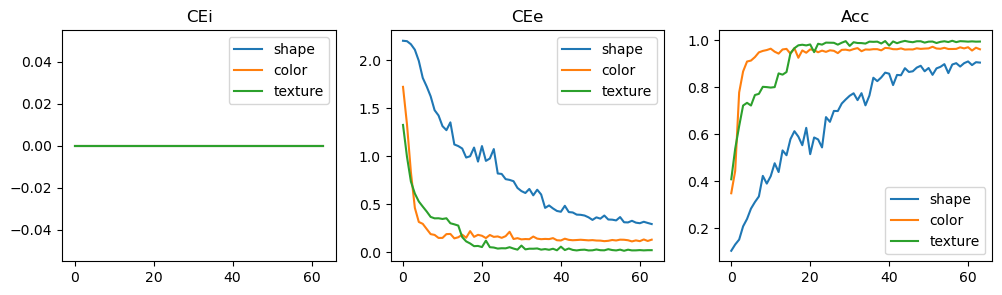

In [11]:
import matplotlib.pyplot as plt
valid_mod_records = torch.load(os.path.join(start_folder, "valid_mod_records.pth"))
modalities = ["shape", "color", "texture"]
loss_types = ["CEi", "CEe", "Acc"]
plt.figure(figsize=(12, 3))
for j, nam in enumerate(loss_types):
    for i, mod in enumerate(modalities):
        plt.subplot(1, 3, j+1)
        plt.plot(valid_mod_records[i, :, j], label=mod)
        plt.title(nam)
        plt.legend()
plt.savefig(os.path.join(results_folder, "valid_mod_records.svg"), format="svg")
plt.show()